# Region Searching for KBMOD

The point of this notebook is to do step-by-step exploration of the DEEP dataset that was first run through KBMOD for the first set of papers. That work was led by Hayden Smotherman, hence the reference to that name.

The "Steven" name that appears is Steven Stetzler, who inherited the responsibilities of properly re/processing the entire DEEP dataset through data acquired through 2023.

### Basic Idea
Here we are connecting to an existing Butler/repository with the intent of carrying out queries to find data suitable for KBMOD to use.

#### FAQ

Q: Who wrote this, and when?\
A: Colin Orion Chandler (coc123@uw.edu), late January 2024.

Q: What are the basic requirements to run this?\
A: (a) Epyc access, (b) with the appropriate (LSST w_2022_06) weekly build active, (c) permissions to access the repo_path mentioned below, and (d) an acceptable Kernel in the Jupyter-Hub of Epyc (user or global).

Q: Why don't we just query the DB (e.g., PostGres, SQLite) to get what we need?\
A: Because (a) the underlying schema can (and has/does) change, and (b) the underlying DB does not contain views, meaning that we would have to recreate the very complex relational mapping ourselves. Moreover, aside from (b) being very challenging, the relationship mapping recreation would fail due to the reasons mentioned in (a).

### Initial Setup

In [1]:
# Import packages needed to run the notebook
import lsst
import lsst.daf.butler as dafButler

import os
import glob

import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed

import time
from dateutil import parser

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

import progressbar

from astropy.time import Time  # for converting Butler visitInfo.date (TAI) to UTC strings
from astropy import units as u
from astropy.coordinates import SkyCoord

import pickle

In [2]:
# We will use some kind of multiprocessing in a few places. Let's see what the sytsem thinks we have available.
# NOTE: we could set limits on executors later using this value, if desired. 2/6/2024 COC

available_cpus = multiprocessing.cpu_count()
print(f"{available_cpus} CPUs were reported as available by the multiprocessing module.")

96 CPUs were reported as available by the multiprocessing module.


In [3]:
# this code will run in different environments, so we need somewhere (not the working directory) to save output
basedir = f'{os.environ["HOME"]}/kbmod_tmp'
os.makedirs(basedir, exist_ok=True)

In [4]:
# set up the Butler
# NOTE: the repo path contains configs that point us to the underlying registry (DB)
# NOTE: do NOT assume there is write protection! (i.e., don't make changes)
repo_path = f"/epyc/users/smotherh/DEEP/PointingGroups/butler-repo"
butler = dafButler.Butler(repo_path)

#### Collections
1. Explore the available collections
2. Construct a list of the collections containing the data we care about.

Different collections hold different datasets.

For the Hayden DEEP repo, the collections we are concerned with are organized by pointing groups (discrete regions on the sky).

We want to figure out what those are, how they are named, and what else is available.

We will also dump a full list of collection names to disk. \
NOTE: as of 2/1/2024, there are 1,292 named collections in the repo.


In [5]:
def get_collection_names(butler, basedir, verbose=False, export=True):
    """
    Making this a function 2/6/2024 COC.
    """
    all_collection_names = []

    for c in sorted(butler.registry.queryCollections("*")):
        all_collection_names.append(c)

    if export == True:
        outfile = f"{basedir}/all_collection_names.lst"
        with open(outfile, "w") as f:
            for c in all_collection_names:
                print(c, file=f)

    if verbose:
        message = f"Found {len(all_collection_names)} collections in the Butler."
        if export == True:
            message += f' Wrote to "{outfile}".'
        print(message)
    return all_collection_names

In [6]:
all_collection_names = get_collection_names(butler=butler, basedir=basedir, verbose=True, export=True)

Found 1292 collections in the Butler. Wrote to "/astro/users/coc123/kbmod_tmp/all_collection_names.lst".


In [7]:
# We looked through the collections already.
# We will string manipulate to get to what we need.
# Previously, we used a list file on disk. (This could be a better option for some users.)


def get_desired_collections(all_collections_list, desired_collection_list=None):
    """
    Produce a list of collections that will be used for querying the Butler.

    If desired_collection_list is None, then a hard-wired "default" approach
    (for Haden/DEEP) is carried out, requiring:
        1. "Pointing" must be in the collection name.
        2. "/imdiff_r/" must be in the collection name.
        3. "/2021" may not be in the collection name.

    Otherwise, desired_collection_list can be either
        1. a Python list of desired collection names, or
        2. a filename (ending in .lst) that specifies the desired collections.
    Either way, the collection names are verified against the (required) collections_list.

    Made this into a function 2/6/2024 COC.

    NOTE/TODO: untested are the supplied list and list file approaches.
    """

    desired_collections = []

    if desired_collection_list == None:
        for collection_name in all_collection_names:
            if (
                "Pointing" in collection_name
                and "/imdiff_r" in collection_name
                and "/2021" not in collection_name
            ):
                desired_collections.append(collection_name)
    else:
        if type(desired_collection_list) == type(""):
            with open(desired_collection_list, "r") as f:
                for line in f:
                    desired_collections.append(line.strip())
        else:
            for entry in desired_collection_list:
                desired_collections.append(entry)
    #
    # Validate entries
    for entry in desired_collections:
        if entry not in all_collections_list:
            raise KeyError(f'"{entry}" is not in the master list of collections supplied.')
    #
    return desired_collections

In [8]:
desired_collections = get_desired_collections(all_collections_list=all_collection_names)
desired_collections

['PointingGroup006/imdiff_r',
 'PointingGroup008/imdiff_r',
 'PointingGroup009/imdiff_r',
 'PointingGroup016/imdiff_r',
 'PointingGroup018/imdiff_r',
 'PointingGroup019/imdiff_r',
 'PointingGroup021/imdiff_r',
 'PointingGroup023/imdiff_r']

In [9]:
# ASIDE: there is a set of collections with dates in their names
#   (e.g., PointingGroup006/imdiff_r/20211110T184421Z).
# Those (only?) have the following datasetTypes, (so we use the name without the date for all the datasetTypes):
# Across all collections, we see the following numbers by datasetType:
# 47383      deepDiff_diaSrc
# 8          deepDiff_diaSrc_schema
# 47383      deepDiff_differenceExp
# 29445      deepDiff_warpedExp
# 8          imageDifference_config
# 17942      imageDifference_log
# 47383      imageDifference_metadata
# 8          packages

# which is too little? we we will snag the parent Collections (stripping dates)

#### datasetTypes

Here we explore another dimension of the Butler: datasetType.

tldr; we just care about one currently: deepDiff_differenceExp

In [10]:
# TIMING NOTE: about 2 minutes here
#
# Maybe a KBMOD user must know which datasetType(s) they need?
# Here we show how to explore them to figure that out.
#
# NOTE: we tested two approaches,
#   (a) iterating over desired_collections, and
#   (b) supply desired_collections.
# The output was the same, but the iterating method took 268s, and the supplied method took 97s.
# There *was* a point where we thought we were seeing different results depending on the approach,
# but this has been sorted out. (COC suspects a testing break in a loop somwhere.)
# COC NTS: [TODO] function, [TODO] caching


def getDatasetTypeStats(butler, overwrite=False):
    """
    Get information on all datasetTypes found in a Butler.
    TODO implement caching if desired. If not, get rid of overwrite option.
    2/1/2024 COC
    """
    datasetTypes = {}

    cache_file = f"{basedir}/dataset_types.csv"
    cache_exists = False
    if len(glob.glob(cache_file)) > 0:
        cache_exists = True

    if overwrite == False and cache_exists == True:
        print(f"Recycling {cache_file} as overwrite was False...")
        with open(cache_file, "r") as f:
            for line in f:
                print(line)
                line = line.strip().split(",")
                datasetTypes[line[0]] = int(line[1])
        print(f"Read {len(datasetTypes)} datasetTypes from disk.")
        return datasetTypes

    q = sorted(butler.registry.queryDatasetTypes())

    with progressbar.ProgressBar(max_value=len(q)) as bar:
        for j, dt in enumerate(q):
            n = 0
            for i, ref in enumerate(
                butler.registry.queryDatasets(datasetType=dt, collections=desired_collections)
            ):
                n += 1
            if n > 0:
                if dt.name not in datasetTypes:
                    datasetTypes[dt.name] = 0
                datasetTypes[dt.name] += n
            bar.update(j)

    if cache_exists == False or overwrite == True:
        print(f"Saving {len(datasetTypes)} datasetTypes to {cache_file} now...")
        with open(cache_file, "w") as f:
            for key in datasetTypes:
                print(f"{key},{datasetTypes[key]}", file=f)
    else:
        print(f"Saw {len(datasetTypes)} datasetTypes.")
    return datasetTypes

In [11]:
%%time
# TIMING NOTE: this takes roughly 2.5 minutes without cache (2/6/2024 COC)
datasetTypes = getDatasetTypeStats(butler=butler, overwrite=False)

Recycling /astro/users/coc123/kbmod_tmp/dataset_types.csv as overwrite was False...
assembleCoadd_config,8

assembleCoadd_log,268

assembleCoadd_metadata,700

cal_ref_cat,122856

calexp,47403

calexpBackground,47403

calibrate_config,8

calibrate_log,17961

calibrate_metadata,47403

characterizeImage_config,8

characterizeImage_log,18290

characterizeImage_metadata,47423

deepCoadd,693

deepCoadd_directWarp,167085

deepCoadd_inputMap,693

deepCoadd_psfMatchedWarp,167085

deepDiff_diaSrc,47383

deepDiff_diaSrc_schema,8

deepDiff_differenceExp,47383

deepDiff_warpedExp,29445

gaia_DR1_v1,524283

icExp,47423

icExpBackground,47423

icSrc,47423

icSrc_schema,8

imageDifference_config,8

imageDifference_log,17942

imageDifference_metadata,47383

isr_config,8

isr_log,18290

isr_metadata,48422

makeWarp_config,8

makeWarp_log,64924

makeWarp_metadata,167085

overscanRaw,48422

overscan_config,8

overscan_log,18290

overscan_metadata,48422

packages,32

postISRCCD,48422

ps1_pv3_3pi_20170110,

In [12]:
# The number of records for each datasetType.
# This may be especially useful for users who do not yet know which datasetType(s) they need.

print(f"Across all collections, we see the following numbers by datasetType: ")
for dt in datasetTypes:
    print(f"{datasetTypes[dt]!s:10} {dt}")

Across all collections, we see the following numbers by datasetType: 
8          assembleCoadd_config
268        assembleCoadd_log
700        assembleCoadd_metadata
122856     cal_ref_cat
47403      calexp
47403      calexpBackground
8          calibrate_config
17961      calibrate_log
47403      calibrate_metadata
8          characterizeImage_config
18290      characterizeImage_log
47423      characterizeImage_metadata
693        deepCoadd
167085     deepCoadd_directWarp
693        deepCoadd_inputMap
167085     deepCoadd_psfMatchedWarp
47383      deepDiff_diaSrc
8          deepDiff_diaSrc_schema
47383      deepDiff_differenceExp
29445      deepDiff_warpedExp
524283     gaia_DR1_v1
47423      icExp
47423      icExpBackground
47423      icSrc
8          icSrc_schema
8          imageDifference_config
17942      imageDifference_log
47383      imageDifference_metadata
8          isr_config
18290      isr_log
48422      isr_metadata
8          makeWarp_config
64924      makeWarp_log
167085 

In [13]:
# This is the datasetType that we care about.
# NOTE: we should allow this to be a list in case a user needs multiple.
desired_datasetTypes = ["deepDiff_differenceExp"]

### Visit Detector Region (VDR) Querying

Here we will query the Butler and extract all of the "visit_detector_region" information.\
At this stage we are gathering:
1. dataIds for all future queries
2. lsst.sphgeom.region objects

In [14]:
def get_vdr_data(butler, desired_collections, desired_datasetTypes):
    """

    Made as function 2/6/2024 COC.
    """
    # VDR === Visit Detector Region
    # VDRs hold what we need in terms of region hashes and unique dataIds.
    # NOTE: this typically takes < 5s to run 2/1/2024 COC
    # NOTE: tried iterating over desired_collections vs supplying desired_collections; same output 2/1/2024 COC

    vdr_dict = {"data_id": [], "region": [], "detector": []}
    #     vdr_ids = []
    #     vdr_regions = []
    #     vdr_detectors = []

    for dt in desired_datasetTypes:
        datasetRefs = butler.registry.queryDimensionRecords(
            "visit_detector_region", datasets=dt, collections=desired_collections
        )
        for ref in datasetRefs:
            vdr_dict["data_id"].append(ref.dataId)
            vdr_dict["region"].append(
                ref.region
            )  # keeping as objects for now; should .encode() for caching/export
            vdr_dict["detector"].append(ref.detector)  # 2/2/2024 COC
            # BUT if we decided to export this or cache this, we should write the encode() version to disk
            #
            example_vdr_ref = ref  # this leaves a VDR Python object we can play with
            # other data available:
            #    id = ref.id# id -- e.g., 1592350 (for DEEP dataset, I think UUIDs for newer Butlers)
            #    visit = ref.dataId.full['visit'] # e.g., 946725
            # vdr_filters.append(ref.dataId.full['band']) # e.g., VR
            # vdr_detectors.append(ref.dataId.full['detector']) # e.g., 1
    df = pd.DataFrame.from_dict(vdr_dict)
    return df, example_vdr_ref

In [15]:
%%time
# TIMING NOTE: requires about 2 seconds 2/6/2024 COC
df, example_vdr_ref = get_vdr_data(
    butler=butler, desired_collections=desired_collections, desired_datasetTypes=desired_datasetTypes
)

CPU times: user 2.17 s, sys: 89 ms, total: 2.26 s
Wall time: 2.77 s


In [16]:
df

,data_id,region,detector
0,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847372525065534...,1
1,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847381014554984...,1
2,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847383417970056...,1
3,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847382159041213...,1
4,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847381374341414...,1
...,...,...,...
47378,"(instrument, detector, visit)","ConvexPolygon([UnitVector3d(0.987608537646486,...",62
47379,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9876085083003562...,62
47380,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9876085761885252...,62
47381,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9876085761885252...,62


In [17]:
print(f"We found {len(df['data_id'])} regions spanning the {len(desired_collections)} desired collections.")

We found 47383 regions spanning the 8 desired collections.


In [18]:
# For demonstration purposes we still have the last "ref" from the last cell's iteration
example_vdr_ref

visit_detector_region.RecordClass(instrument='DECam', detector=62, visit=946176, region=ConvexPolygon([UnitVector3d(0.9876086828694174, -0.13336028508776862, -0.08272922024438323), UnitVector3d(0.9873378171284917, -0.13332652431396907, -0.08595389916869185), UnitVector3d(0.9881047366097594, -0.12752395595185462, -0.08594573955553172), UnitVector3d(0.9883760335240734, -0.12755303452468866, -0.0827226676235914)]))

In [19]:
# This is the unique dataId we would need to retrieve this specific image later
example_vdr_ref.dataId

{instrument: 'DECam', detector: 62, visit: 946176}

In [20]:
# The unique dataId is made up of the following attributes:
print(
    f"example_vdr_ref.instrument = {example_vdr_ref.instrument}, \
    example_vdr_ref.detector = {example_vdr_ref.detector}, \
    example_vdr_ref.visit = {example_vdr_ref.visit}"
)

example_vdr_ref.instrument = DECam,     example_vdr_ref.detector = 62,     example_vdr_ref.visit = 946176


In [21]:
# This is the region hash we would use for "region matching" later
example_vdr_ref.region.encode()

b'p\xddnE\x86}\x9a\xef?\x0f\xc3\x84\'\xf3\x11\xc1\xbf\x80\x8a_\xff\xbd-\xb5\xbf\x04xUzE\x98\xef?\x94\x15\xcf\xf2\xd7\x10\xc1\xbf\x9d\xa9\xe4!\x13\x01\xb6\xbf\x1d_\x18\xd3\x8d\x9e\xef?\x80\x87"z\xb4R\xc0\xbff\x1d\x9f<\x8a\x00\xb6\xbf\xe4Z\x84\xc6\xc6\xa0\xef?\x1f\x01\xe5g\xa8S\xc0\xbf\xba\xc9\x14\x10P-\xb5\xbf'

In [22]:
# We check to see if we can crawl to other data from the dataId (False means no).
example_vdr_ref.dataId.hasRecords()

False

# Dataframe Assembly

This used to contain more, but after I moved everything to a dictionary, then a DF, this became less important.
TODO determine where this should go. Or remove.

In [23]:
%%time

# Save the dataframe to a pickle file for easier resuming of the notebook
# Size was < 20 Mb 2/5/2024 COC
# COC Note: this was not that useful, maybe TODO remove
df_filename = f"{basedir}/region_search_df.pickle"
df.to_pickle(df_filename)

CPU times: user 417 ms, sys: 33 ms, total: 450 ms
Wall time: 544 ms


In [24]:
# load the pickle
# df = pd.read_pickle(file_name)

### Instrument handling
Some Butler queries require the instrument to be specified.\
For now, we are just supplying the one we care about (KLUDGE).\
It's a list so we can mix-and-match shift-and-stack across instruments(!).\
NOTE: will leave this as a list for future-proofing purpose

In [25]:
def getInstruments(butler, vdr_ids, first_instrument_only=True):
    """Iterate through our records to determine which instrument(s) are involved.
    Return a list of the identified instruments.
    If first_instrument_only is True, stop as soon as we found an instrument.
    """
    # KLUDGE: snag the instrument name of the first record we find in a visitInfo query.
    instrument_names = []
    for i, dataId in enumerate(vdr_ids):
        visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
        instrument_name = visitInfo.instrumentLabel
        if instrument_name not in instrument_names:
            print(f'Found {instrument_name}. Adding to "desired_instruments" now.')
            instrument_names.append(instrument_name)
        if first_instrument_only == True and len(instrument_names) > 0:
            print(
                f"WARNING: we are not iterating over all rows to find instruments, just taking the first one."
            )
            break
    return instrument_names

In [26]:
%%time
desired_instruments = getInstruments(butler=butler, vdr_ids=df["data_id"])

Found DECam. Adding to "desired_instruments" now.
CPU times: user 1.82 s, sys: 344 ms, total: 2.17 s
Wall time: 2.51 s


### Butler Retrieval Example

A quick stop to see how we can grab the full Butler record via a dataId.

In [27]:
%%time
# Back to the dataId, we can actually fetch the image from the Butler
# TIMING NOTE: it takes 1 to 2 seconds to do this, so we won't be able to do this at scale

example_butler_get = butler.get(
    desired_datasetTypes[0], collections=desired_collections, dataId=example_vdr_ref.dataId
)

CPU times: user 1.64 s, sys: 309 ms, total: 1.95 s
Wall time: 3.52 s


In [28]:
example_butler_get.detector.getId()

62

In [29]:
example_butler_get.filterLabel.bandLabel

'VR'

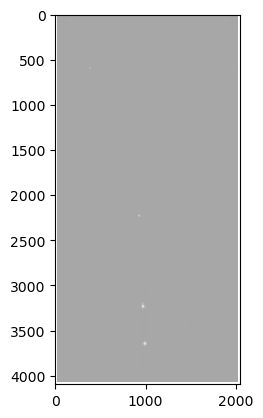

In [30]:
# we can even view the image right here
plt.imshow(example_butler_get.image.array, cmap="gray")

In [31]:
# There IS a WCS here, which we did not see in the earlier VDR
example_butler_get.wcs

FITS standard SkyWcs:
Sky Origin: (352.4630539808, -4.8516830845)
Pixel Origin: (1126.14, 1991.36)
Pixel Scale: 0.262593 arcsec/pixel

In [32]:
# We can access all kinds of metadata this way.
# NOTE: keywords are source data-dependent.
# NOTE: this linkage works with butler.get() but not necessarily elsewhere.
meta = example_butler_get.getInfo().getMetadata()

print(f"Here are all the keywords available from this image:")
for k in meta.keys():
    print(k)

Here are all the keywords available from this image:
NEXTEND
PROCTYPE
PRODTYPE
PIXSCAL1
PIXSCAL2
FILENAME
TELESCOP
OBSERVAT
INSTRUME
EXPREQ
OBSID
TIME-OBS
OPENSHUT
EXPNUM
OBJECT
OBSTYPE
CAMSHUT
PROGRAM
OBSERVER
PROPOSER
DTPI
PROPID
EXCLUDED
SEQID
SEQNUM
SEQTOT
AOS
BCAM
GUIDER
SKYSTAT
FILTER
INSTANCE
ERRORS
TELEQUIN
TELSTAT
RA
DEC
TELRA
TELDEC
HA
ZD
AZ
DOMEAZ
ZPDELRA
ZPDELDEC
TELFOCUS
VSUB
GSKYPHOT
LSKYPHOT
WINDSPD
WINDDIR
PRESSURE
DIMMSEE
DIMM2SEE
MASS2
ASTIG1
ASTIG2
OUTTEMP
AIRMASS
GSKYVAR
GSKYHOT
LSKYVAR
LSKYHOT
LSKYPOW
MSURTEMP
MAIRTEMP
UPTRTEMP
LWTRTEMP
PMOSTEMP
UTN-TEMP
UTS-TEMP
UTW-TEMP
UTE-TEMP
PMN-TEMP
PMS-TEMP
PMW-TEMP
PME-TEMP
DOMELOW
DOMEHIGH
DOMEFLOR
G-MEANX
G-MEANY
DONUTFS4
DONUTFS3
DONUTFS2
DONUTFS1
G-FLXVAR
G-MEANXY
DONUTFN1
DONUTFN2
DONUTFN3
DONUTFN4
TIME_RECORDED
G-FEEDBK
G-CCDNUM
DOXT
G-MAXX
FADZ
FADY
FADX
G-MODE
FAYT
DODZ
DODY
DODX
MULTIEXP
SKYUPDAT
G-SEEING
G-TRANSP
G-MEANY2
DOYT
G-LATENC
LUTVER
FAXT
G-MAXY
G-MEANX2
SISPIVER
CONSTVER
HDRVER
DTPROPID
DTCALDAT
DTSITE


### URI / URL / Path Handling
Here we grab URIs for the dataIds we need.

In [33]:
# NOTE: getURIs() does not work as you'd think (i.e., it only handles a single dataId)
# butler.getURIs(desired_datasetTypes[0], vdr_ids, collections=desired_collections)

In [34]:
# The single-thead approach (below) requires some 2 hours to execute. So instead we will multiprocess.
# paths = [butler.getURI(desired_datasetTypes[0], dataId=dataId, collections=desired_collections) for dataId in vdr_ids]


def chunked_dataIds(dataIds, chunk_size=200):
    """Yield successive chunk_size chunks from dataIds."""
    for i in range(0, len(dataIds), chunk_size):
        yield dataIds[i : i + chunk_size]


def get_uris(dataIds_chunk, repo_path, desired_datasetTypes, desired_collections):
    """Fetch URIs for a list of dataIds."""
    chunk_uris = []
    butler = dafButler.Butler(repo_path)
    for dataId in dataIds_chunk:
        try:
            uri = butler.getURI(desired_datasetTypes[0], dataId=dataId, collections=desired_collections)
            uri = uri.geturl()  # Convert to URL string
            chunk_uris.append(uri)
        except Exception as e:
            print(f"Failed to retrieve path for dataId {dataId}: {e}")
    return chunk_uris


def getURIs(butler, dataIds, repo_path, desired_datasetTypes, desired_collections, overwrite=False):
    """
    Get URIs from a Butler for a set of dataIDs.
    Cache results to disk for future runs.
    TODO: consider exporting as CSV so we can validate URIs against dataIds. 2/6/2024 COC
    Updated 2/5/2024 COC
    """
    paths = []

    cache_file = f"{basedir}/uri_cache.lst"
    cached_exists = False
    if len(glob.glob(cache_file)) > 0:
        cached_exists = True

    if cached_exists == True and overwrite == False:
        with open(cache_file, "r") as f:
            for line in f:
                paths.append(line.strip())
        print(f"Recycled {len(paths)} paths from {cache_file} as overwrite was {overwrite}.")
        return paths

    # Prepare dataId chunks
    dataId_chunks = list(chunked_dataIds(dataIds))

    # Execute get_uris in parallel and preserve order
    with ProcessPoolExecutor() as executor:
        # Initialize progress bar
        with progressbar.ProgressBar(max_value=len(dataId_chunks)) as bar:
            # Use map to execute get_uris on each chunk and maintain order
            result_chunks = list(
                executor.map(
                    get_uris,
                    dataId_chunks,
                    [repo_path] * len(dataId_chunks),
                    [desired_datasetTypes] * len(dataId_chunks),
                    [desired_collections] * len(dataId_chunks),
                )
            )

            for i, chunk_uris in enumerate(result_chunks):
                paths.extend(chunk_uris)  # Add the retrieved URIs to the main list
                bar.update(i)

    with open(cache_file, "w") as f:
        for path in paths:
            print(path, file=f)
        print(f"Wrote {len(paths)} paths to disk for caching purposes.")

    return paths

In [35]:
%%time

# TIMING NOTE: This required 90s uncached 2/5/2024 COC

df["uri"] = getURIs(
    butler=butler,
    dataIds=df["data_id"],
    repo_path=repo_path,
    desired_datasetTypes=desired_datasetTypes,
    desired_collections=desired_collections,
    overwrite=False,
)

Recycled 47383 paths from /astro/users/coc123/kbmod_tmp/uri_cache.lst as overwrite was False.
CPU times: user 25.3 ms, sys: 14.2 ms, total: 39.5 ms
Wall time: 108 ms


In [36]:
# example URI
df["uri"].iloc()[0]

'file:///epyc/users/smotherh/DEEP/PointingGroups/butler-repo/PointingGroup021/imdiff_r/20210723T174135Z/deepDiff_differenceExp/20190927/VR/VR_DECam_c0007_6300.0_2600.0/898286/deepDiff_differenceExp_DECam_VR_VR_DECam_c0007_6300_0_2600_0_898286_S29_PointingGroup021_imdiff_r_20210723T174135Z.fits'

### Timestamp Handling
Here we will access the timestamp (datetime) information from the Butler for our records.

In [37]:
%%time
# Now we want to get metadata like datetime, exposure time, etc.
for i, dataId in enumerate(df["data_id"]):
    visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
    print(i, visitInfo.date, visitInfo.exposureTime, visitInfo.boresightRaDec)
    break
# We have the visitInfo object for the exploration below.

0 DateTime("2019-09-27T00:20:59.932016000", TAI) 120.0 (351.3806941054, -5.2403083277)
CPU times: user 114 ms, sys: 13 ms, total: 127 ms
Wall time: 157 ms


In [38]:
# That visitInfo.date format may not look familiar. Let's find out why:
type(visitInfo.date)

lsst.daf.base.dateTime.dateTime.DateTime

In [39]:
# Let's convert to a plain string, UTC (handles 37 s offset).
t = Time(str(visitInfo.date).split('"')[1], format="isot", scale="tai")
str(t.utc)

'2019-09-27T00:20:22.932'

In [40]:
# New parallel version with order-preservation redone 2/7/2024 COC


# Define get_timestamps at the top level of your module
def get_timestamps(dataIds_chunk, repo_path, desired_collections):
    chunked_data = []
    butler = dafButler.Butler(repo_path)
    for dataId in dataIds_chunk:
        try:
            visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
            t = Time(str(visitInfo.date).split('"')[1], format="isot", scale="tai")
            tutc = str(t.utc)
            chunked_data.append(tutc)
        except Exception as e:
            print(f"Failed to retrieve timestamp for dataId {dataId}: {e}")
    return chunked_data


def getTimestamps(dataIds, overwrite=False):
    timestamps = []
    cache_file = f"{basedir}/vdr_timestamps.lst"

    if not overwrite and glob.glob(cache_file):
        print("Overwrite is False, so we will read the timestamps from file now...")
        with open(cache_file, "r") as f:
            timestamps = [line.strip() for line in f]
        print(f"Recycled {len(timestamps)} from {cache_file}.")
        return timestamps

    def chunked_dataIds(dataIds, chunk_size=200):
        for i in range(0, len(dataIds), chunk_size):
            yield dataIds[i : i + chunk_size]

    dataId_chunks = list(chunked_dataIds(dataIds))

    with ProcessPoolExecutor() as executor:
        # Adjust the executor.map call to pass additional arguments to get_timestamps
        result_chunks = list(
            executor.map(
                get_timestamps,
                dataId_chunks,
                [repo_path] * len(dataId_chunks),
                [desired_collections] * len(dataId_chunks),
            )
        )

    timestamps = [timestamp for chunk in result_chunks for timestamp in chunk]

    if overwrite or not glob.glob(cache_file):
        with open(cache_file, "w") as f:
            for ts in timestamps:
                print(ts, file=f)
        print(f"Wrote {len(timestamps)} lines to {cache_file} for future use.")

    print(f"Obtained {len(timestamps)} timestamps.")
    return timestamps

In [41]:
%%time

# TIMING NOTE: this took < 5 minutes 2/5/2024 COC
df["ut"] = getTimestamps(dataIds=df["data_id"], overwrite=False)

Overwrite is False, so we will read the timestamps from file now...
Recycled 47383 from /astro/users/coc123/kbmod_tmp/vdr_timestamps.lst.
CPU times: user 24.3 ms, sys: 8.18 ms, total: 32.5 ms
Wall time: 30.5 ms


In [42]:
df["ut"]

0        2019-09-27T00:20:22.932
1        2019-09-27T00:22:51.015
2        2019-09-27T00:25:19.136
3        2019-09-27T00:27:47.118
4        2019-09-27T00:30:15.537
                  ...           
47378    2020-10-17T04:00:51.409
47379    2020-10-17T04:03:19.873
47380    2020-10-17T04:05:48.949
47381    2020-10-17T04:08:17.445
47382    2020-10-17T04:10:46.218
Name: ut, Length: 47383, dtype: object

In [43]:
# This is for coming back to later to make sure the stamps line up
# IGNORE FOR NOW 2/6/2024 COC
# for i in range(0,len(vdr_ids),1000):
#     dataId = vdr_ids[i]
#     visitInfo = butler.get("calexp.visitInfo", dataId=dataId, collections=desired_collections)
#     t = Time(str(visitInfo.date).split('"')[1], format="isot", scale="tai")
#     tutc = str(t.utc)
#     print(f"{i!s:5}: {tutc} for {dataId}. Dict had: {id_to_date[dataId]}")

### Working with the Regions

We still don't know what will be ideal to do for Region Search.\
So, to start with, we will work on extract the (RA, Dec) of the (1) center coordinate of a chip, and (2) four corners associated with a chip.

#### We will start with corners (i.e., quadilateral vertices from the convexPolygon sphgeom.regions)

In [44]:
def getRegionCorners(region):
    """
    Using the 2D boundingBox() from an input region (convexPolygon), we
    extract the (RA, Dec) coordinates of each vertex.
    As there are four vertices, the input object is a quadrilateral.
    2/2/2024 COC
    """
    corners = []
    bbox = region.getBoundingBox()
    corners.append((bbox.getLon().getA().asDegrees(), bbox.getLat().getA().asDegrees()))
    corners.append((bbox.getLon().getA().asDegrees(), bbox.getLat().getB().asDegrees()))
    corners.append((bbox.getLon().getB().asDegrees(), bbox.getLat().getA().asDegrees()))
    corners.append((bbox.getLon().getB().asDegrees(), bbox.getLat().getB().asDegrees()))
    return corners

In [45]:
# Example
corners = getRegionCorners(example_vdr_ref.region)
corners

[(352.30950511932116, -4.930880058593892),
 (352.30950511932116, -4.7450820235469715),
 (352.64644359666477, -4.930880058593892),
 (352.64644359666477, -4.7450820235469715)]

In [46]:
def getMinMaxRaDec(ra_dec_touples, verbose=False):
    """
    Highly unoptimized way to find and return
    (minRA, maxRA) and (minDec, MaxDec).
    2/2/2024 COC
    """
    min_ra = min([i[0] for i in ra_dec_touples])
    min_dec = min([i[1] for i in ra_dec_touples])
    max_ra = max([i[0] for i in ra_dec_touples])
    max_dec = max([i[1] for i in ra_dec_touples])
    if verbose:
        print(f"RA range: {min_ra} to {max_ra}")
        print(f"Dec range: {min_dec} to {max_dec}")
    return (min_ra, max_ra), (min_dec, max_dec)

In [47]:
# Example
getMinMaxRaDec(ra_dec_touples=corners)

((352.30950511932116, 352.64644359666477),
 (-4.930880058593892, -4.7450820235469715))

#### Centers

It may be easer to just work with center (RA, Dec) coordinates.\
We can later store this in a DB (e.g., Postgres) for cone searches.

In [48]:
def getCenterRaDec(region):
    """
    We pull the 2D boundingBox (not the boundingBox3d) from a region.
    Then we extract the center's (RA, Dec) coordinates.
    2/2/2024 COC
    """
    bbox_center = region.getBoundingBox().getCenter()
    ra = bbox_center.getLon().asDegrees()
    dec = bbox_center.getLat().asDegrees()
    return (ra, dec)

In [49]:
getCenterRaDec(example_vdr_ref.region)

(352.477974357993, -4.837981041070432)

In [50]:
%%time
df["center_coord"] = [getCenterRaDec(i) for i in df["region"]]

CPU times: user 499 ms, sys: 14.5 ms, total: 513 ms
Wall time: 513 ms


In [51]:
len(df["center_coord"])

47383

In [52]:
df["center_coord"].iloc()[0]

(351.0694028401149, -4.336598368890197)

CPU times: user 1.48 s, sys: 11.3 ms, total: 1.49 s
Wall time: 1.49 s


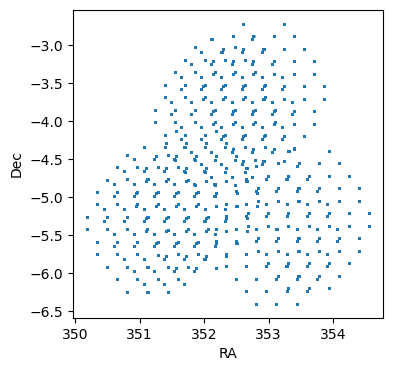

In [53]:
%%time
# Let us visualize where on the sky our chip centers reside
fig = plt.figure(figsize=(4, 4))
plt.xlabel("RA")
plt.ylabel("Dec")
plt.scatter(
    [i[0] for i in df["center_coord"].iloc()], [i[1] for i in df["center_coord"].iloc()], s=1, alpha=0.5
)

The DECam mosaic shape is clearly visible, thrice.\
There is an offset from each of the three pointings, too.

In the most simple approach, each of these "dots" represents a set of images that can be fed to KBMOD.

In [54]:
# look at the first dataId, which does not show up in a pretty way in the DF
df["data_id"].iloc[0]

{instrument: 'DECam', detector: 1, visit: 898286}

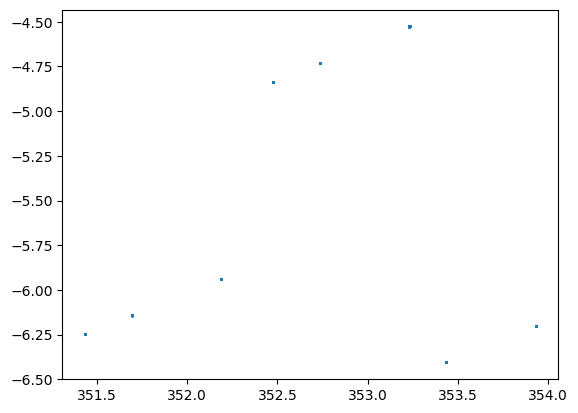

In [55]:
# Let us look at just detector 62 pointings.
# This will give us a decent idea of how many pointings there are (here, 8).

df62 = df[df["detector"] == 62]
plt.clf()
plt.scatter(*zip(*df62["center_coord"]), s=1, alpha=0.5)

In [56]:
# chip62_coord0 = df62['center_coord'][0]

### Region Matching
Here region matching means comparing two lsst.sphgeom.region objects.\
Purpose: to see if they have any overlap whatsoever. \
NOTE: a partial or full overlap is called an "intersection" in sphgeom lingo.

NOTE: Work in progress, but pausing this avenue for now. 2/2/2024 COC

In [57]:
# manual region-region matching between all chips
# NOTE: estimate time is 1 hour, so skipping this for now

doit = False
if doit == True:
    lastTime = time.time()

    matches = {}

    with progressbar.ProgressBar(max_value=len(vdr_regions)) as bar:
        for i, l in enumerate(vdr_regions):
            my_id = vdr_ids[i]
            matches[my_id] = []
            for j, r in enumerate(vdr_regions):
                if i == j:
                    continue
                if l.intersects(r):
                    matches[my_id].append(vdr_ids[j])
            bar.update(i)
    elapsed = round(time.time() - lastTime, 1)
    print(f"It took {elapsed} seconds.")

To be continued...

### HTM Exploration

In [58]:
# Colin playing 1/15/2024 COC
def getHTMstuff(ra, dec, level=7, verbose=False):
    """
    1/16/2024 COC inception.
    A function that
        1. Fetches an HTM ID for a pixelization of a user-supplied level.
        2. Determines the angular size (radius, in arcseconds) of the pixelization level.
    LSST stores the unique HTM ID for level 7 pixelization in the Butler, hence the default level=7.
    """
    pixelization = lsst.sphgeom.HtmPixelization(level)

    try:  # kludges; use the Butler way, but if being passed normal numbers, use those
        ra = ra.asDegrees()
    except AttributeError as msg:
        pass
    try:
        dec = dec.asDegrees()
    except AttributeError as msg:
        pass

    htm_id = pixelization.index(
        lsst.sphgeom.UnitVector3d(
            # sphgeom.LonLat.fromDegrees(ra.asDegrees(), dec.asDegrees())
            lsst.sphgeom.LonLat.fromDegrees(ra, dec)
        )
    )
    circle = pixelization.triangle(htm_id).getBoundingCircle()
    scale = circle.getOpeningAngle().asDegrees() * 3600.0
    level = pixelization.getLevel()
    if verbose:
        print(f"HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.")
    return (htm_id, scale)

In [59]:
getHTMstuff(df["center_coord"].iloc()[0][0], df["center_coord"].iloc()[0][1], verbose=True)

HTM ID=189361 at level=7 is bounded by a circle of radius ~1895.11 arcsec.


(189361, 1895.111766130883)

In [60]:
dsRefs = butler.registry.queryDatasets(
    datasetType=desired_datasetTypes[0], htm7=147116, collections=desired_collections
)
print(len(sorted(dsRefs)))

0


To be continued...

### Brute force approach for (small) discrete datasets

The idea here is that we can organize discrete piles of images, such as DEEP, DDF.

In [61]:
def find_overlapping_coords(df, uncertainty_radius, overwrite=False):
    """

    Added caching 2/5/2024 COC
    """
    cache_file = f"{basedir}/overlapping_sets.pickle"

    cache_exists = False
    if len(glob.glob(cache_file)) > 0:
        cache_exists = True

    if overwrite == False and cache_exists == True:
        with open(cache_file, "rb") as f:
            print(f"Recycling {cache_file} as overwrite={overwrite}.")
            overlapping_sets = pickle.load(f)
            return overlapping_sets

    df_copy = df.copy()

    # Assuming uncertainty_radius is provided as a float in arcseconds
    uncertainty_radius_as = uncertainty_radius * u.arcsec

    all_coords = SkyCoord(
        ra=[x[0] for x in df_copy["center_coord"]] * u.degree,
        dec=[x[1] for x in df_copy["center_coord"]] * u.degree,
    )

    overlapping_sets = {}
    set_counter = 1
    processed_data_ids = []

    periodic_update_counter = 0
    with progressbar.ProgressBar(max_value=len(all_coords)) as bar:
        for index, coord in enumerate(all_coords):
            data_id = df_copy.iloc[index]["data_id"]
            if data_id not in processed_data_ids:
                distances = (
                    coord.separation(all_coords).to(u.arcsec).value
                )  # Convert distances to arcseconds as numeric values

                # Perform comparison as numeric values, bypassing direct unit comparison
                within_radius = (distances <= uncertainty_radius_as.value) & (distances > 0)

                if any(within_radius):
                    overlapping_indices = [
                        i
                        for i, distance in enumerate(distances)
                        if (distance <= uncertainty_radius_as.value) and i != index
                    ]
                    overlapping_data_ids = df_copy.iloc[overlapping_indices]["data_id"].tolist()
                    overlapping_data_ids.append(data_id)

                    processed_data_ids.extend(overlapping_data_ids)

                    overlapping_sets[f"set_{set_counter}"] = overlapping_data_ids
                    set_counter += 1
            #
            # mitigate too much output 2/5/2024 COC
            periodic_update_counter += 1
            if periodic_update_counter >= 250:
                periodic_update_counter = 0
                bar.update(index)

    with open(cache_file, "wb") as f:
        pickle.dump(overlapping_sets, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Saved overlapping_sets to {cache_file} for caching purposes.")

    return overlapping_sets

In [62]:
%%time

# TIMING NOTE: this takes about 1.25 hours [TODO update that number]
# TODO test caching

overlapping_sets = find_overlapping_coords(df=df, uncertainty_radius=30, overwrite=False)

Recycling /astro/users/coc123/kbmod_tmp/overlapping_sets.pickle as overwrite=False.
CPU times: user 402 ms, sys: 46.6 ms, total: 449 ms
Wall time: 446 ms


In [63]:
print(f"There are {len(overlapping_sets.keys())} discrete chip-level pointings.")  # should be 488

There are 488 discrete chip-level pointings.


#### Exploring the overlapping_sets

CPU times: user 367 ms, sys: 17.3 ms, total: 385 ms
Wall time: 383 ms


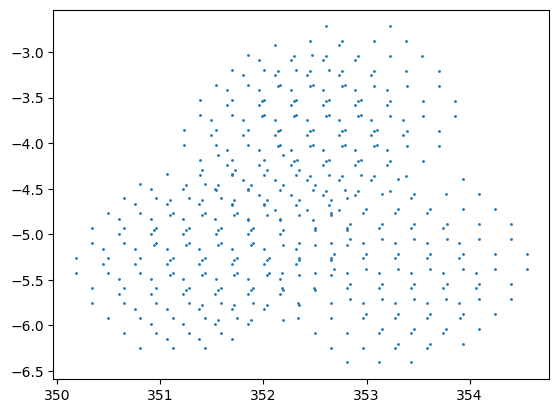

In [64]:
%%time

# Looking at the processed data.

# Create a lookup table for data_id to center_coord
id_to_coord = df.set_index("data_id")["center_coord"].to_dict()

# Preparing for bulk plotting (if every point uses the same label, adjust as needed)
coords = [id_to_coord[overlapping_sets[p][0]] for p in overlapping_sets]
x_coords, y_coords = zip(*coords)  # Assuming coords are tuples or lists

# Plotting in bulk
plt.scatter(x_coords, y_coords, s=1)

In [65]:
df["ut"].iloc()[0]

'2019-09-27T00:20:22.932'

<timed exec>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


CPU times: user 9.55 s, sys: 815 ms, total: 10.4 s
Wall time: 9.86 s


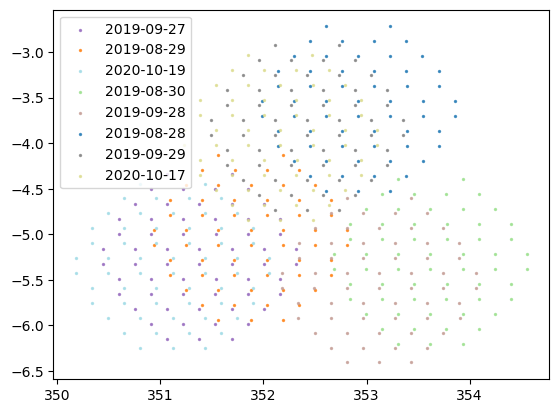

In [66]:
%%time

# TIMING NOTE: this requires about 7 seconds

# Convert "ut" column to datetime
df["ut_datetime"] = pd.to_datetime(df["ut"])

# Create lookup tables for data_id to center_coord and ut_datetime
id_to_coord = df.set_index("data_id")["center_coord"].to_dict()
id_to_date = df.set_index("data_id")["ut_datetime"].dt.date.to_dict()

# Extract unique dates and create a color map
unique_dates = sorted(set(id_to_date.values()))
date_to_color = {date: i for i, date in enumerate(unique_dates)}
norm = Normalize(vmin=0, vmax=len(unique_dates) - 1)
cmap = get_cmap("tab20", len(unique_dates))  # Choose a colormap that fits the data

# Preparing data for plotting
coords = [id_to_coord[overlapping_sets[p][0]] for p in overlapping_sets]
dates = [id_to_date[overlapping_sets[p][0]] for p in overlapping_sets]
colors = [cmap(norm(date_to_color[date])) for date in dates]

# Plotting
lcount = 0
for (x, y), color, date in zip(coords, colors, dates):
    lcount += 1
    plt.scatter(x, y, color=color, label=date.strftime("%Y-%m-%d"), alpha=0.75, s=2)

# To avoid duplicate labels in the legend, handle legend entries manually
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removing duplicates
plt.legend(by_label.values(), by_label.keys())
plt.savefig(f"{basedir}/pointings.pdf")
# plt.show()

In [67]:
df.columns

Index(['data_id', 'region', 'detector', 'uri', 'ut', 'center_coord',
       'ut_datetime'],
      dtype='object')

In [68]:
# Here are the unique dates found in the discrete dataset
unique_dates = sorted(set(id_to_date.values()))
unique_dates

[datetime.date(2019, 8, 28),
 datetime.date(2019, 8, 29),
 datetime.date(2019, 8, 30),
 datetime.date(2019, 9, 27),
 datetime.date(2019, 9, 28),
 datetime.date(2019, 9, 29),
 datetime.date(2020, 10, 17),
 datetime.date(2020, 10, 19)]

##### Double-checking a single date

In [69]:
df.iloc()[0]

data_id                             (instrument, detector, visit)
region          ConvexPolygon([UnitVector3d(0.9847372525065534...
detector                                                        1
uri             file:///epyc/users/smotherh/DEEP/PointingGroup...
ut                                        2019-09-27T00:20:22.932
center_coord              (351.0694028401149, -4.336598368890197)
ut_datetime                            2019-09-27 00:20:22.932000
Name: 0, dtype: object

In [70]:
id_to_date[df["data_id"].iloc()[0]]

datetime.date(2019, 9, 27)

In [71]:
id_to_coord[df["data_id"].iloc()[0]]

(351.0694028401149, -4.336598368890197)

In [72]:
# We will make a dataframe with just the date we are checking
df20190828 = df[df["ut_datetime"].dt.date == parser.parse("2019-08-28").date()]
len(df20190828)

6267

CPU times: user 931 ms, sys: 22.3 ms, total: 953 ms
Wall time: 952 ms


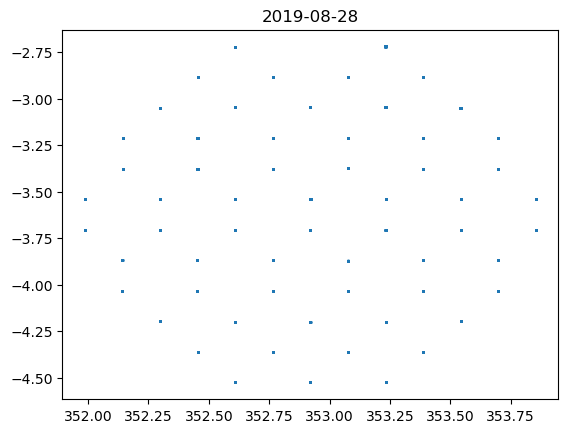

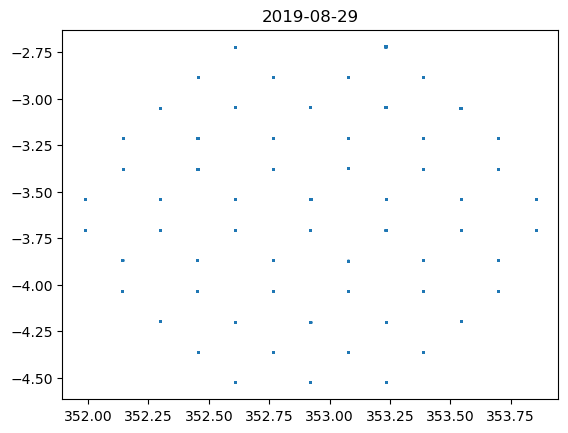

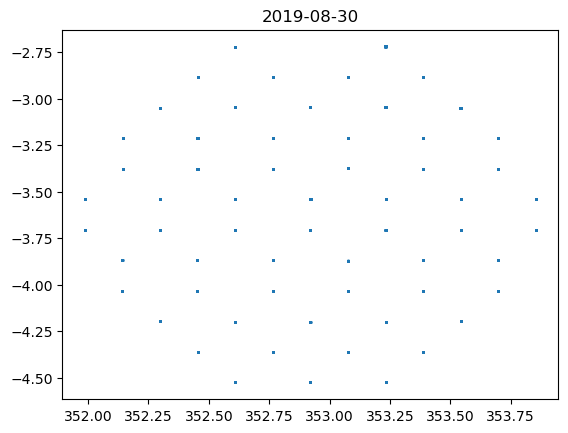

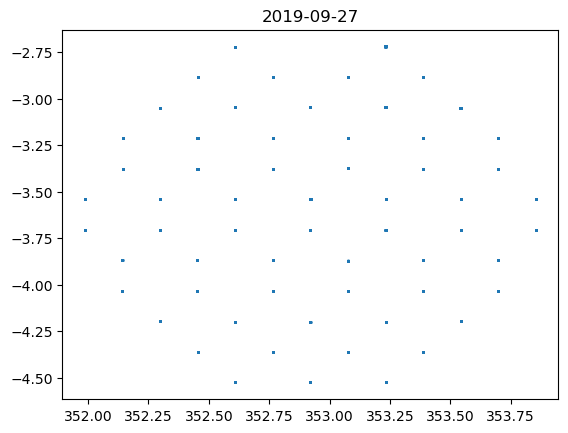

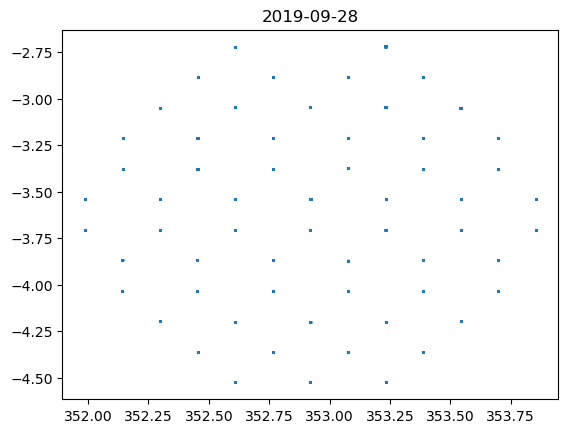

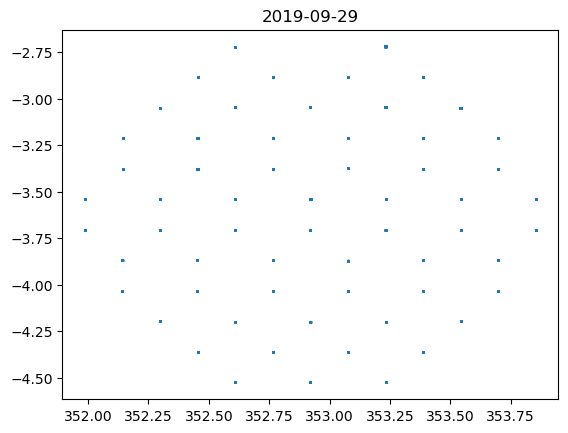

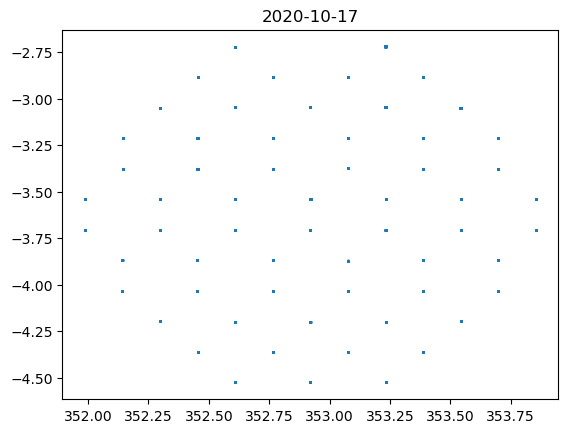

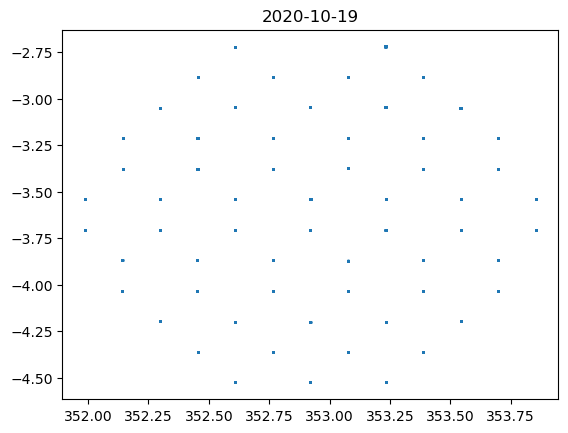

In [73]:
%%time
# Visualize all of the unique dates, one at a time.
for dt in unique_dates:
    fig = plt.figure()
    tmpdf = df[df["ut_datetime"].dt.date == parser.parse("2019-08-28").date()]
    plt.scatter(*zip(*tmpdf["center_coord"]), s=1, alpha=0.5)
    plt.title(f"{dt}")
del tmpdf

### (RA, Dec) searching of image sets

In [74]:
# Fetch an (RA, Dec) pair from an image set.
first_set_name = list(overlapping_sets.keys())[0]
first_sets_data_id = overlapping_sets[first_set_name][0]
searching_ra_dec = df.set_index("data_id")["center_coord"].to_dict()[first_sets_data_id]

print(f'"{first_set_name}" is the first set name in overlapping_sets.')
print(f"Its first record dataId: {first_sets_data_id}.")
print(f"It has an (RA, Dec) coordinate of {searching_ra_dec}.")

"set_1" is the first set name in overlapping_sets.
Its first record dataId: {instrument: 'DECam', detector: 1, visit: 898287}.
It has an (RA, Dec) coordinate of (351.0695696334572, -4.336293374423113).


In [75]:
def ra_dec_search_overlapping_sets(df, overlapping_sets, ra_dec, search_radius, verbose=False):
    """
    2/6/2024 COC
    Implementing an extremely basic (RA, Dec) query functionality.
    This will work within the overlapping_sets framework.
    """
    ra_dec_coord = SkyCoord(ra=ra_dec[0] * u.degree, dec=ra_dec[1] * u.degree)

    all_centers = []
    all_labels = []

    id_to_coord = df.set_index("data_id")["center_coord"].to_dict()

    for i, set_name in enumerate(list(overlapping_sets.keys())):
        all_labels.append(set_name)
        center_data_id = overlapping_sets[set_name][0]
        # print(f"See set_name is {set_name} and center_data_id is {center_data_id}.", flush=True)
        center_coord = id_to_coord[center_data_id]
        all_centers.append(center_coord)

    all_centers = SkyCoord(
        ra=[x[0] for x in all_centers] * u.degree,
        dec=[x[1] for x in all_centers] * u.degree,
    )

    distances = ra_dec_coord.separation(
        all_centers
    )  # .to(u.arcsec).value  # Convert distances to arcseconds as numeric values
    within_radius = (distances <= search_radius) & (
        distances >= 0
    )  # ≥ (not >) because we could supply the an exact match

    results = []
    for i, item in enumerate(within_radius):
        if item == True:
            results.append(all_labels[i])
    if verbose:
        print(f"We found {len(results)} sets that are within {search_radius} of {ra_dec}.")
    return results

In [76]:
# Find matching image sets.
# With 1*u.arcminute we would only find set_1 (where we got searching_ra_dec).
# With 15*u.arcminute, we find 3 others (for a total of 4).
search_radius = 14 * u.arcminute
ra_dec_search_results = ra_dec_search_overlapping_sets(
    df=df,
    overlapping_sets=overlapping_sets,
    ra_dec=searching_ra_dec,
    search_radius=search_radius,
    verbose=True,
)
ra_dec_search_results

We found 4 sets that are within 14.0 arcmin of (351.0695696334572, -4.336293374423113).


['set_1', 'set_3', 'set_4', 'set_68']

[[(350.9194972863569, -4.410893881734765), (350.9194972863569, -4.261692867111463), (351.2196419805575, -4.410893881734765), (351.2196419805575, -4.261692867111463)], [(350.7636367448476, -4.57504777569875), (350.7636367448476, -4.425558984666654), (351.06385253666514, -4.57504777569875), (351.06385253666514, -4.425558984666654)], [(351.07489718950103, -4.574714132229647), (351.07489718950103, -4.425184883190398), (351.3752749096747, -4.574714132229647), (351.3752749096747, -4.425184883190398)], [(351.1044786505892, -4.535445547532834), (351.1044786505892, -4.385657669534001), (351.40443040247294, -4.535445547532834), (351.40443040247294, -4.385657669534001)]]


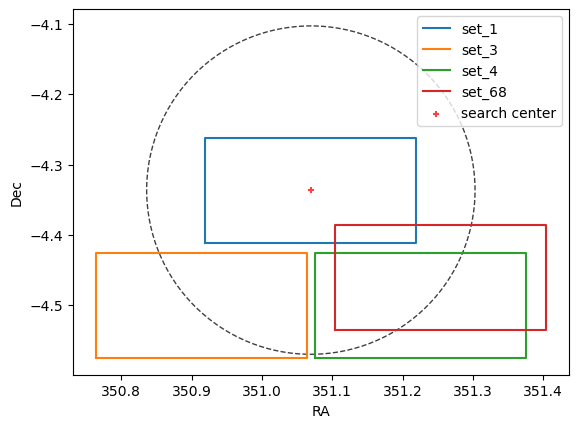

In [77]:
matching_regions = []
id_to_region = df.set_index("data_id")["region"].to_dict()

for set_name in ra_dec_search_results:
    matching_regions.append(id_to_region[overlapping_sets[set_name][0]])

all_corners = [getRegionCorners(region) for region in matching_regions]
print(all_corners)

for i, quad in enumerate(all_corners):
    ra_bounds, dec_bounds = getMinMaxRaDec(quad)
    #
    coords = []
    coords.append((ra_bounds[0], dec_bounds[0]))
    coords.append((ra_bounds[0], dec_bounds[1]))
    coords.append((ra_bounds[1], dec_bounds[1]))
    coords.append((ra_bounds[1], dec_bounds[0]))
    coords.append((ra_bounds[0], dec_bounds[0]))  # close the "shape"
    #
    plt.plot([x[0] for x in coords], [x[1] for x in coords], label=ra_dec_search_results[i])

plt.scatter(
    searching_ra_dec[0],
    searching_ra_dec[1],
    s=25,
    marker="+",
    alpha=0.75,
    label=f"search center",
    color="red",
)
circle = plt.Circle(
    (searching_ra_dec[0], searching_ra_dec[1]),
    search_radius.to(u.degree).value,
    color="black",
    alpha=0.75,
    fill=False,
    label="search area",
    linestyle="--",
)
plt.legend()
plt.xlabel(f"RA")
plt.ylabel("Dec")
ax = plt.gca()
ax.add_patch(circle)
ax.set_aspect("equal", adjustable="box")

### (RA, Dec) searching of our DataFrame (more general case)
It is far faster to search overlapping_sets as there are few of these to inspect.
A more general case, however, would be to simply find all images within a radius of a sky coordinate.

In [78]:
def ra_dec_search_df(df, ra_dec, search_radius, verbose=False):
    """
    2/6/2024 COC
    Implementing a basic (RA, Dec) query function for our derived Pandas dataframe.
    """

    ra_dec_coord = SkyCoord(ra=ra_dec[0] * u.degree, dec=ra_dec[1] * u.degree)

    all_centers = SkyCoord(
        ra=[x[0] for x in df["center_coord"].iloc()] * u.degree,
        dec=[x[1] for x in df["center_coord"].iloc()] * u.degree,
    )

    distances = ra_dec_coord.separation(all_centers)
    within_radius = (distances <= search_radius) & (
        distances >= 0
    )  # ≥ (not >) because we could supply the an exact match

    results = df[within_radius]

    if verbose:
        print(f"We found {len(results.index)} matches within {search_radius} of {ra_dec}.")
    return results

In [79]:
%%time
ra_dec_search_radius = 3 * u.arcsec
ra_dec_search_results_df = ra_dec_search_df(
    df=df, ra_dec=searching_ra_dec, search_radius=ra_dec_search_radius, verbose=True
)
ra_dec_search_results_df

We found 95 matches within 3.0 arcsec of (351.0695696334572, -4.336293374423113).
CPU times: user 805 ms, sys: 21.7 ms, total: 827 ms
Wall time: 825 ms


,data_id,region,detector,uri,ut,center_coord,ut_datetime
0,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847372525065534...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:20:22.932,"(351.0694028401149, -4.336598368890197)",2019-09-27 00:20:22.932
1,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847381014554984...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:22:51.015,"(351.0695696334572, -4.336293374423113)",2019-09-27 00:22:51.015
2,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847383417970056...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:25:19.136,"(351.0696571334576, -4.336293374415341)",2019-09-27 00:25:19.136
3,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847382159041213...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:27:47.118,"(351.069611300124, -4.336293374419411)",2019-09-27 00:27:47.118
4,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847381374341414...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:30:15.537,"(351.0695696451088, -4.336265319377865)",2019-09-27 00:30:15.537
...,...,...,...,...,...,...,...
90,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847391753851408...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:02:58.424,"(351.06998627728365, -4.3363483733857136)",2019-09-27 04:02:58.424
91,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847400909178194...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:05:27.654,"(351.0703196106188, -4.336348373356122)",2019-09-27 04:05:27.654
92,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847397935953284...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:07:56.159,"(351.07019878847524, -4.336321429412502)",2019-09-27 04:07:56.159
93,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847392459182945...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:10:25.141,"(351.069986300126, -4.336293374386118)",2019-09-27 04:10:25.141


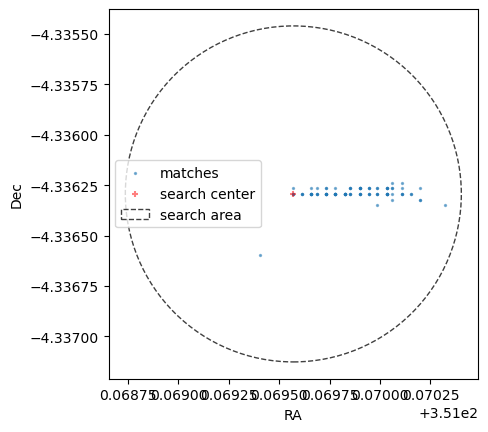

In [80]:
# Plot the centers
plt.scatter(
    [x[0] for x in ra_dec_search_results_df["center_coord"]],
    [x[1] for x in ra_dec_search_results_df["center_coord"]],
    s=2,
    alpha=0.5,
    label="matches",
)
plt.scatter(
    searching_ra_dec[0], searching_ra_dec[1], color="red", s=20, alpha=0.5, marker="+", label="search center"
)
circle = plt.Circle(
    (searching_ra_dec[0], searching_ra_dec[1]),
    ra_dec_search_radius.to(u.degree).value,
    color="black",
    alpha=0.75,
    fill=False,
    label="search area",
    linestyle="--",
)
plt.xlabel(f"RA")
plt.ylabel("Dec")
ax = plt.gca()
ax.add_patch(circle)
plt.legend()
ax.set_aspect("equal", adjustable="box")

These are the 95 matching center coordinates.\
These may look far off, but this is just the scale.\
We can plot the entire chip area on-sky, as we did earlier overlapping_sets.

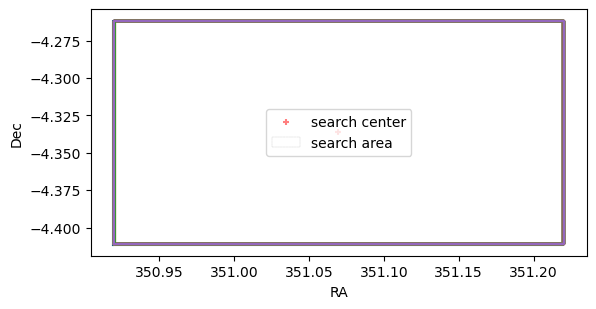

In [81]:
# Plot the centers
# plt.scatter([x[0] for x in ra_dec_search_results_df["center_coord"]], [x[1] for x in ra_dec_search_results_df["center_coord"]], s=2, alpha=0.5, label="matches")
plt.scatter(
    searching_ra_dec[0], searching_ra_dec[1], color="red", s=20, alpha=0.5, marker="+", label="search center"
)
for quad in [getRegionCorners(x) for x in ra_dec_search_results_df["region"]]:
    ra_bounds, dec_bounds = getMinMaxRaDec(quad)
    #
    coords = []
    coords.append((ra_bounds[0], dec_bounds[0]))
    coords.append((ra_bounds[0], dec_bounds[1]))
    coords.append((ra_bounds[1], dec_bounds[1]))
    coords.append((ra_bounds[1], dec_bounds[0]))
    coords.append((ra_bounds[0], dec_bounds[0]))  # close the "shape"
    #
    plt.plot([x[0] for x in coords], [x[1] for x in coords]),  # label=ra_dec_search_results[i])
circle = plt.Circle(
    (searching_ra_dec[0], searching_ra_dec[1]),
    ra_dec_search_radius.to(u.degree).value,
    color="black",
    alpha=0.75,
    fill=False,
    label="search area",
    linestyle="--",
    linewidth=0.1,
)
plt.xlabel(f"RA")
plt.ylabel("Dec")
ax = plt.gca()
ax.add_patch(circle)
plt.legend()
ax.set_aspect("equal", adjustable="box")

# Recap and Master Functions
Here is a master function that takes a repo_path and returns \
(1) a Pandas dataframe with needed info, and\
(2) a dictionary with the images in discrete piles (sets).

In [82]:
def retrieve_image_sets(
    repo_path,
    basedir="default",
    desired_datasetTypes=["deepDiff_differenceExp"],
    overwrite=False,
    overlap_uncertainty_radius_arcsec=30,
):
    """
    2/6/2024 COC
    """
    if basedir == "default":
        basedir = f'{os.environ["HOME"]}/kbmod_tmp'
        print(f'Changing "default" basedir to {basedir} now.')

    os.makedirs(basedir, exist_ok=True)

    #     repo_path = f"/epyc/users/smotherh/DEEP/PointingGroups/butler-repo"
    butler = dafButler.Butler(repo_path)

    all_collection_names = get_collection_names(butler=butler, basedir=basedir, verbose=True, export=True)
    desired_collections = get_desired_collections(all_collections_list=all_collection_names)
    #     datasetTypes = getDatasetTypeStats(butler=butler, overwrite=False) # not used 2/6/2024 COC
    #     desired_datasetTypes = ["deepDiff_differenceExp"]
    df, example_vdr_ref = get_vdr_data(
        butler=butler, desired_collections=desired_collections, desired_datasetTypes=desired_datasetTypes
    )
    desired_instruments = getInstruments(butler=butler, vdr_ids=df["data_id"])
    df["center_coord"] = [getCenterRaDec(i) for i in df["region"]]
    df["uri"] = getURIs(
        butler=butler,
        dataIds=df["data_id"],
        repo_path=repo_path,
        desired_datasetTypes=desired_datasetTypes,
        desired_collections=desired_collections,
        overwrite=overwrite,
    )

    df["ut"] = getTimestamps(dataIds=df["data_id"], overwrite=overwrite)
    df["ut_datetime"] = pd.to_datetime(df["ut"])
    overlapping_sets = find_overlapping_coords(
        df=df, uncertainty_radius=overlap_uncertainty_radius_arcsec, overwrite=overwrite
    )
    return df, overlapping_sets

In [83]:
%%time

# Example
# TIMING NOTE: this requires about 7 seconds to run ***with everything already cached***.
df1, overlapping_sets1 = retrieve_image_sets(
    repo_path=f"/epyc/users/smotherh/DEEP/PointingGroups/butler-repo"
)

Changing "default" basedir to /astro/users/coc123/kbmod_tmp now.
Found 1292 collections in the Butler. Wrote to "/astro/users/coc123/kbmod_tmp/all_collection_names.lst".
Found DECam. Adding to "desired_instruments" now.
Recycled 47383 paths from /astro/users/coc123/kbmod_tmp/uri_cache.lst as overwrite was False.
Overwrite is False, so we will read the timestamps from file now...
Recycled 47383 from /astro/users/coc123/kbmod_tmp/vdr_timestamps.lst.
Recycling /astro/users/coc123/kbmod_tmp/overlapping_sets.pickle as overwrite=False.
CPU times: user 5.1 s, sys: 618 ms, total: 5.72 s
Wall time: 6.88 s


The other high-level function is searching the overlapping sets for a specific (RA, Dec) coordinate.

In [84]:
ra_dec_search_results1 = ra_dec_search_overlapping_sets(
    df=df1,
    overlapping_sets=overlapping_sets1,
    ra_dec=(351.0695696334572, -4.336293374423113),
    search_radius=15 * u.arcminute,
    verbose=True,
)
ra_dec_search_results1

We found 4 sets that are within 15.0 arcmin of (351.0695696334572, -4.336293374423113).


['set_1', 'set_3', 'set_4', 'set_68']

In [85]:
ra_dec_search_results2 = ra_dec_search_df(
    df=df, ra_dec=(351.0695696334572, -4.336293374423113), search_radius=3 * u.arcsec, verbose=True
)
ra_dec_search_results2

We found 95 matches within 3.0 arcsec of (351.0695696334572, -4.336293374423113).


,data_id,region,detector,uri,ut,center_coord,ut_datetime
0,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847372525065534...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:20:22.932,"(351.0694028401149, -4.336598368890197)",2019-09-27 00:20:22.932
1,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847381014554984...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:22:51.015,"(351.0695696334572, -4.336293374423113)",2019-09-27 00:22:51.015
2,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847383417970056...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:25:19.136,"(351.0696571334576, -4.336293374415341)",2019-09-27 00:25:19.136
3,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847382159041213...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:27:47.118,"(351.069611300124, -4.336293374419411)",2019-09-27 00:27:47.118
4,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847381374341414...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T00:30:15.537,"(351.0695696451088, -4.336265319377865)",2019-09-27 00:30:15.537
...,...,...,...,...,...,...,...
90,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847391753851408...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:02:58.424,"(351.06998627728365, -4.3363483733857136)",2019-09-27 04:02:58.424
91,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847400909178194...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:05:27.654,"(351.0703196106188, -4.336348373356122)",2019-09-27 04:05:27.654
92,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847397935953284...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:07:56.159,"(351.07019878847524, -4.336321429412502)",2019-09-27 04:07:56.159
93,"(instrument, detector, visit)",ConvexPolygon([UnitVector3d(0.9847392459182945...,1,file:///epyc/users/smotherh/DEEP/PointingGroup...,2019-09-27T04:10:25.141,"(351.069986300126, -4.336293374386118)",2019-09-27 04:10:25.141


# Next Steps

In no particular order:

1. User-specified (RA, Dec) pair:
- from overlapping_sets (DONE 2/7/2024 COC)
- from our extracted Butler data (DONE 2/7/2024 COC)
2. Heat map / histogrammed results.
3. Sky patches approach.
4. Reflex correction.